<a href="https://colab.research.google.com/github/avinash-3102/Cognitive-CodeQuest-2025-Soft-Computing-Coding-Competition-/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement: Disaster-Rescue Swarm Optimization Challenge

> Add blockquote



A powerful earthquake has struck a metropolitan city. Emergency responders need immediate aerial assessment using a swarm of 20 UAVs. The city is divided into 50 zones, each labeled with a priority score based on likelihood of injuries, structural collapse, and fire risk

Swarm Performance Score: 1.16
UAV 0: Assigned zones [11, 29] | Path [11, 29]
UAV 1: Assigned zones [19] | Path [19]
UAV 2: Assigned zones [20] | Path [20]
UAV 3: Assigned zones [2, 6, 40] | Path [2, 6, 40]
UAV 4: Assigned zones [3, 35] | Path [3, 35]
UAV 5: Assigned zones [7, 8, 28, 36] | Path [7, 28, 8, 36]
UAV 6: Assigned zones [4, 17, 30] | Path [4, 17, 30]
UAV 7: Assigned zones [24, 34] | Path [24, 34]
UAV 8: Assigned zones [25, 37] | Path [25, 37]
UAV 9: Assigned zones [0, 27, 33, 41] | Path [0, 27, 33, 41]
UAV 10: Assigned zones [16, 46] | Path [16, 46]
UAV 11: Assigned zones [5, 31, 32, 44] | Path [5, 32, 31, 44]
UAV 12: Assigned zones [12, 15, 22, 26] | Path [12, 22, 15, 26]
UAV 13: Assigned zones [9, 13] | Path [9, 13]
UAV 14: Assigned zones [18, 47] | Path [18, 47]
UAV 15: Assigned zones [14, 39, 48] | Path [14, 39, 48]
UAV 16: Assigned zones [1, 38, 43, 45] | Path [1, 43, 38, 45]
UAV 17: Assigned zones [21] | Path [21]
UAV 18: Assigned zones [49] | Path [49]
UAV 19: Assigned

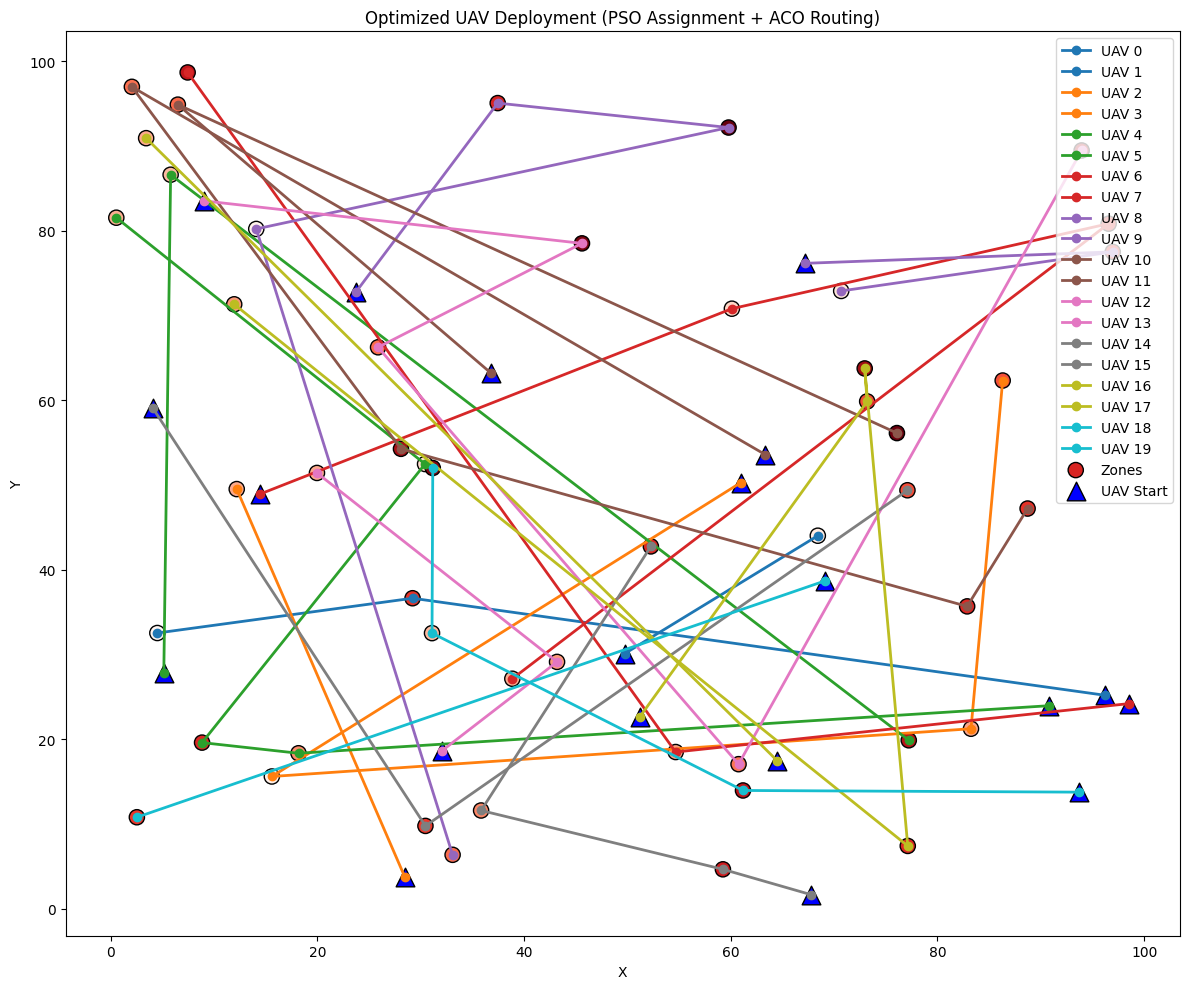

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (increase population and iterations for better results)
n_uavs = 20
n_zones = 50
n_pso_particles = 30
pso_iters = 60
aco_iters = 60

np.random.seed(42)
zone_positions = np.random.rand(n_zones, 2) * 100
zone_priorities = np.random.randint(10, 100, n_zones)
zones = [{'id': i, 'pos': zone_positions[i], 'priority': zone_priorities[i]} for i in range(n_zones)]
uav_positions = np.random.rand(n_uavs, 2) * 100
dists = np.array([[np.linalg.norm(z1['pos']-z2['pos']) for z2 in zones] for z1 in zones])

def fitness(assignments):
    zone_uav_map = {u: [] for u in range(n_uavs)}
    for zone_idx, uav_idx in enumerate(assignments):
        zone_uav_map[uav_idx].append(zone_idx)
    load = [len(zone_uav_map[u]) for u in range(n_uavs)]
    penalty = max(load) - min(load)
    score = sum(zone_priorities[z] for z in range(n_zones)) - penalty * 3
    return score

# PSO for zone assignments
swarm = [np.random.randint(0, n_uavs, n_zones) for _ in range(n_pso_particles)]
velocities = [np.zeros(n_zones) for _ in range(n_pso_particles)]
pbest = [s.copy() for s in swarm]
pbest_scores = [fitness(s) for s in swarm]
gbest = pbest[np.argmax(pbest_scores)]
gbest_score = max(pbest_scores)
w, c1, c2 = 0.7, 0.7, 0.7

for it in range(pso_iters):
    for i, particle in enumerate(swarm):
        r1, r2 = np.random.rand(n_zones), np.random.rand(n_zones)
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest[i] - particle) +
                         c2 * r2 * (gbest - particle))
        particle = particle + velocities[i]
        particle = np.clip(np.round(particle), 0, n_uavs-1).astype(int)
        swarm[i] = particle
        score = fitness(particle)
        if score > pbest_scores[i]:
            pbest[i] = particle.copy()
            pbest_scores[i] = score
            if score > gbest_score:
                gbest = particle.copy()
                gbest_score = score

zone_assignments = {u: [] for u in range(n_uavs)}
for zone_idx, uav_idx in enumerate(gbest):
    zone_assignments[uav_idx].append(zone_idx)

# ACO for path optimization
def run_aco(uav_id, assigned_zones, start_pos, dists, iterations=aco_iters):
    n_z = len(assigned_zones)
    if n_z == 0: return [], 0
    pheromone = np.ones((n_z, n_z))
    local_dists = dists[np.ix_(assigned_zones, assigned_zones)]
    best_path, best_length = None, float('inf')
    for _ in range(iterations):
        path = [0]
        visited = set(path)
        for step in range(1, n_z):
            current = path[-1]
            probs = []
            for j in range(n_z):
                if j in visited: continue
                h = 1 / (local_dists[current, j]+1e-5)
                p = pheromone[current, j] * h**2
                probs.append(p)
            probs = np.array(probs)
            if probs.sum() == 0 or np.isnan(probs).any():
                next_zone = [j for j in range(n_z) if j not in visited][0]
            else:
                probs = probs / probs.sum()
                next_zone = [j for j in range(n_z) if j not in visited][np.random.choice(len(probs), p=probs)]
            path.append(next_zone)
            visited.add(next_zone)
        route_pts = [start_pos] + [zones[assigned_zones[i]]['pos'] for i in path]
        length = sum(np.linalg.norm(route_pts[i]-route_pts[i+1]) for i in range(len(route_pts)-1))
        for i in range(n_z-1):
            pheromone[path[i], path[i+1]] += 2 / (length+1e-5)
            pheromone[path[i], path[i+1]] *= 0.9
        if length < best_length:
            best_path = path
            best_length = length
    return [assigned_zones[i] for i in best_path], best_length

final_paths = {}
total_priority = 0
total_length = 0
for uav_id in range(n_uavs):
    assigned_zones = zone_assignments[uav_id]
    start_pos = uav_positions[uav_id]
    path, length = run_aco(uav_id, assigned_zones, start_pos, dists)
    final_paths[uav_id] = path
    total_priority += sum(zones[idx]['priority'] for idx in path)
    total_length += length

swarm_score = total_priority / (1 + total_length)
print("Swarm Performance Score:", round(swarm_score, 2))
for uav_id in range(n_uavs):
    print(f"UAV {uav_id}: Assigned zones {zone_assignments[uav_id]} | Path {final_paths[uav_id]}")

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, n_uavs))
plt.figure(figsize=(12,10))
for uav_id, path in final_paths.items():
    pts = [uav_positions[uav_id]] + [zone_positions[i] for i in path]
    pts = np.array(pts)
    plt.plot(pts[:,0], pts[:,1], marker='o', linestyle='-', color=colors[uav_id], label=f'UAV {uav_id}', linewidth=2)
plt.scatter(zone_positions[:,0], zone_positions[:,1], c=zone_priorities, cmap='Reds', s=120, edgecolor='black', label='Zones')
plt.scatter(uav_positions[:,0], uav_positions[:,1], marker='^', color='blue', s=180, edgecolor='black', label='UAV Start')
plt.title('Optimized UAV Deployment (PSO Assignment + ACO Routing)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


GA+ACO  Performance Score: 1.18
UAV 0: Assigned zones [17, 49] | Path [17, 49]
UAV 1: Assigned zones [36, 39] | Path [36, 39]
UAV 2: Assigned zones [7, 23, 32] | Path [7, 23, 32]
UAV 3: Assigned zones [3, 21] | Path [3, 21]
UAV 4: Assigned zones [0, 6, 19] | Path [0, 19, 6]
UAV 5: Assigned zones [35, 46] | Path [35, 46]
UAV 6: Assigned zones [37, 44] | Path [37, 44]
UAV 7: Assigned zones [8, 14, 24] | Path [8, 24, 14]
UAV 8: Assigned zones [11, 15, 27, 28] | Path [11, 28, 15, 27]
UAV 9: Assigned zones [9, 29, 43] | Path [9, 29, 43]
UAV 10: Assigned zones [5, 16, 41] | Path [5, 16, 41]
UAV 11: Assigned zones [1, 2, 22, 42] | Path [1, 22, 42, 2]
UAV 12: Assigned zones [31, 47] | Path [31, 47]
UAV 13: Assigned zones [13, 20, 48] | Path [13, 20, 48]
UAV 14: Assigned zones [25, 26] | Path [25, 26]
UAV 15: Assigned zones [4] | Path [4]
UAV 16: Assigned zones [10, 40] | Path [10, 40]
UAV 17: Assigned zones [34, 38] | Path [34, 38]
UAV 18: Assigned zones [12] | Path [12]
UAV 19: Assigned zones

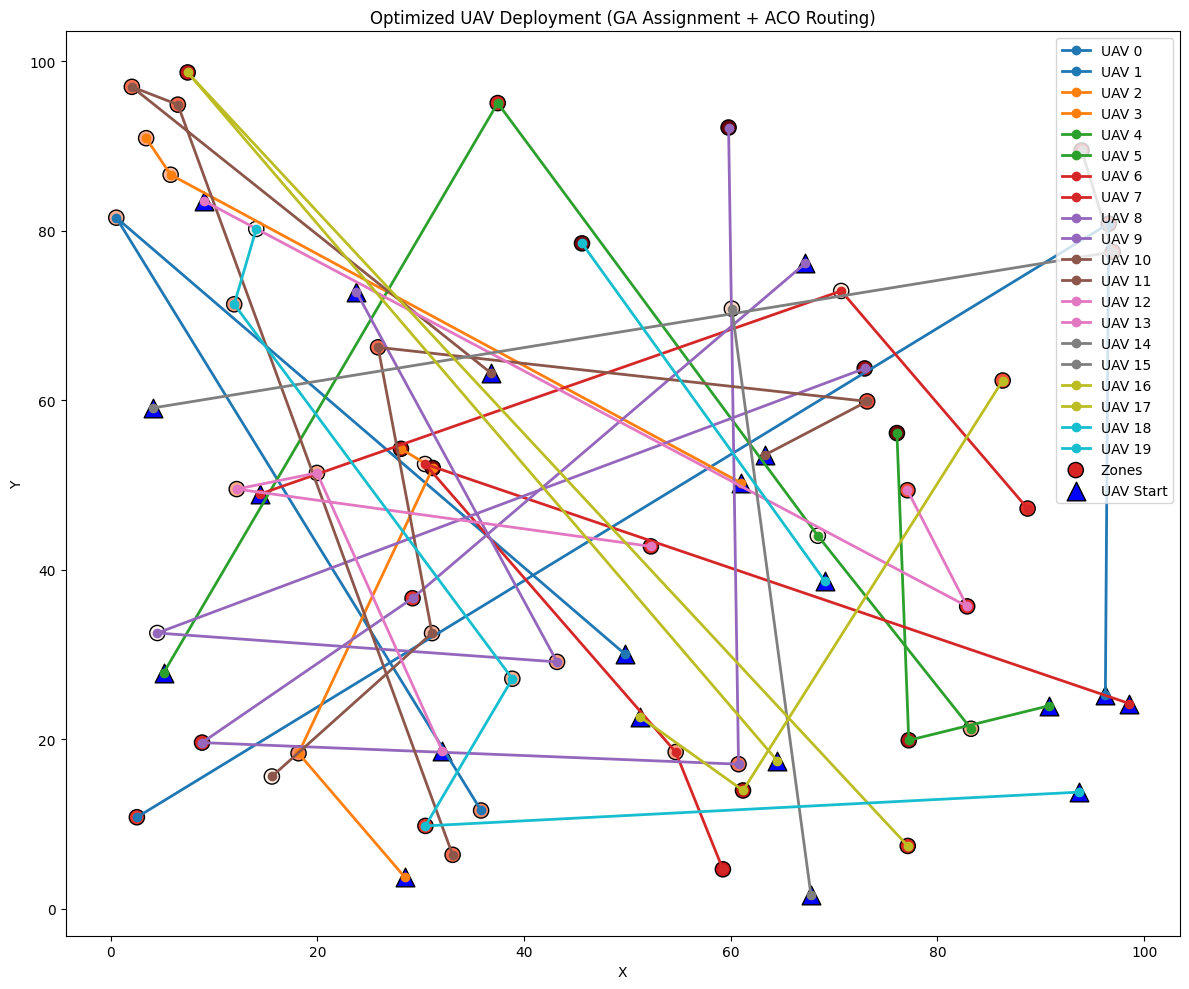

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ----- Problem Parameters -----
n_uavs = 20
n_zones = 50
pop_size = 40
ga_generations = 60
aco_iters = 60

np.random.seed(42)
zone_positions = np.random.rand(n_zones, 2) * 100
zone_priorities = np.random.randint(10, 100, n_zones)
zones = [{'id': i, 'pos': zone_positions[i], 'priority': zone_priorities[i]} for i in range(n_zones)]
uav_positions = np.random.rand(n_uavs, 2) * 100
dists = np.array([[np.linalg.norm(z1['pos']-z2['pos']) for z2 in zones] for z1 in zones])

# ---- GA zone assignment ----
def ga_fitness(assignments):
    zone_uav_map = {u: [] for u in range(n_uavs)}
    for zone_idx, uav_idx in enumerate(assignments):
        zone_uav_map[uav_idx].append(zone_idx)
    load = [len(zone_uav_map[u]) for u in range(n_uavs)]
    penalty = max(load) - min(load)
    score = sum(zone_priorities[z] for z in range(n_zones)) - penalty * 3
    return score

def crossover(parent1, parent2):
    cut = random.randint(1, n_zones-2)
    child = np.concatenate([parent1[:cut], parent2[cut:]])
    return child

def mutate(child, mutation_rate=0.2):
    for i in range(n_zones):
        if random.random() < mutation_rate:
            child[i] = random.randint(0, n_uavs-1)
    return child

# Population initialization
pop = [np.random.randint(0, n_uavs, n_zones) for _ in range(pop_size)]

# Evolution loop
for gen in range(ga_generations):
    fitnesses = [ga_fitness(ind) for ind in pop]
    idx = np.argsort(fitnesses)[::-1][:pop_size // 2]
    parents = [pop[i] for i in idx]
    children = []
    while len(children) < pop_size // 2:
        p1, p2 = random.sample(parents, 2)
        child = crossover(p1, p2)
        child = mutate(child)
        children.append(child)
    pop = parents + children

# Best solution found
best_ga = pop[np.argmax([ga_fitness(ind) for ind in pop])]
zone_assignments_ga = {u: [] for u in range(n_uavs)}
for zone_idx, uav_idx in enumerate(best_ga):
    zone_assignments_ga[uav_idx].append(zone_idx)

# ---- ACO for path/routing per UAV ----
def run_aco(uav_id, assigned_zones, start_pos, dists, iterations=aco_iters):
    n_z = len(assigned_zones)
    if n_z == 0: return [], 0
    pheromone = np.ones((n_z, n_z))
    local_dists = dists[np.ix_(assigned_zones, assigned_zones)]
    best_path, best_length = None, float('inf')
    for _ in range(iterations):
        path = [0]
        visited = set(path)
        for step in range(1, n_z):
            current = path[-1]
            probs = []
            for j in range(n_z):
                if j in visited: continue
                h = 1 / (local_dists[current, j]+1e-5)
                p = pheromone[current, j] * h**2
                probs.append(p)
            probs = np.array(probs)
            if probs.sum() == 0 or np.isnan(probs).any():
                next_zone = [j for j in range(n_z) if j not in visited][0]
            else:
                probs = probs / probs.sum()
                next_zone = [j for j in range(n_z) if j not in visited][np.random.choice(len(probs), p=probs)]
            path.append(next_zone)
            visited.add(next_zone)
        route_pts = [start_pos] + [zones[assigned_zones[i]]['pos'] for i in path]
        length = sum(np.linalg.norm(route_pts[i]-route_pts[i+1]) for i in range(len(route_pts)-1))
        for i in range(n_z-1):
            pheromone[path[i], path[i+1]] += 2 / (length+1e-5)
            pheromone[path[i], path[i+1]] *= 0.9
        if length < best_length:
            best_path = path
            best_length = length
    return [assigned_zones[i] for i in best_path], best_length

final_paths_ga = {}
total_priority_ga = 0
total_length_ga = 0
for uav_id in range(n_uavs):
    assigned_zones = zone_assignments_ga[uav_id]
    start_pos = uav_positions[uav_id]
    path, length = run_aco(uav_id, assigned_zones, start_pos, dists)
    final_paths_ga[uav_id] = path
    total_priority_ga += sum(zones[idx]['priority'] for idx in path)
    total_length_ga += length

swarm_score_ga = total_priority_ga / (1 + total_length_ga)
print("GA+ACO  Performance Score:", round(swarm_score_ga, 2))
for uav_id in range(n_uavs):
    print(f"UAV {uav_id}: Assigned zones {zone_assignments_ga[uav_id]} | Path {final_paths_ga[uav_id]}")

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, n_uavs))
plt.figure(figsize=(12,10))
for uav_id, path in final_paths_ga.items():
    pts = [uav_positions[uav_id]] + [zone_positions[i] for i in path]
    pts = np.array(pts)
    plt.plot(pts[:,0], pts[:,1], marker='o', linestyle='-', color=colors[uav_id], label=f'UAV {uav_id}', linewidth=2)
plt.scatter(zone_positions[:,0], zone_positions[:,1], c=zone_priorities, cmap='Reds', s=120, edgecolor='black', label='Zones')
plt.scatter(uav_positions[:,0], uav_positions[:,1], marker='^', color='blue', s=180, edgecolor='black', label='UAV Start')
plt.title('Optimized UAV Deployment (GA Assignment + ACO Routing)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


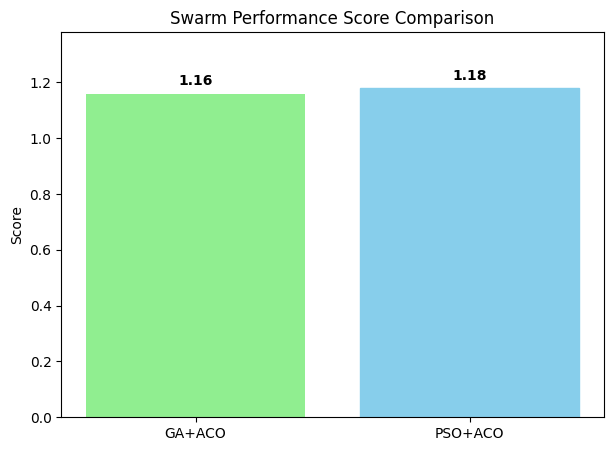

In [ ]:
import matplotlib.pyplot as plt

# Example scores, replace with your actual results!
methods = ['GA+ACO', 'PSO+ACO']
scores = [ round(swarm_score, 2), round(swarm_score_ga, 2)]

plt.figure(figsize=(7,5))
bars = plt.bar(methods, scores, color=['lightgreen'])

# Highlight higher score
best_idx = scores.index(max(scores))
bars[best_idx].set_color('skyblue')

plt.title('Swarm Performance Score Comparison')
plt.ylabel('Score')
plt.ylim(0, max(scores)+0.2)
for i, v in enumerate(scores):
    plt.text(i, v+0.03, f'{v:.2f}', ha='center', fontweight='bold')
plt.show()
